<a href="https://colab.research.google.com/github/DaeseungLee/Autoencoder-mnist/blob/main/Autoencoder_mnist_Tensorflow2_0_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



4423680/4422102 [==============================] - 0s 0us/step


In [20]:
latent_dim = 64

# Autoencoder 클래스는 keras의 모델을 상속받는다.
class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28,28)),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim)

In [25]:
autoencoder.compile(
    optimizer='adam',
    loss=losses.MeanSquaredError()
)

In [26]:
autoencoder.fit(x_train, 
                x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0400 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0123 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.008

In [27]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

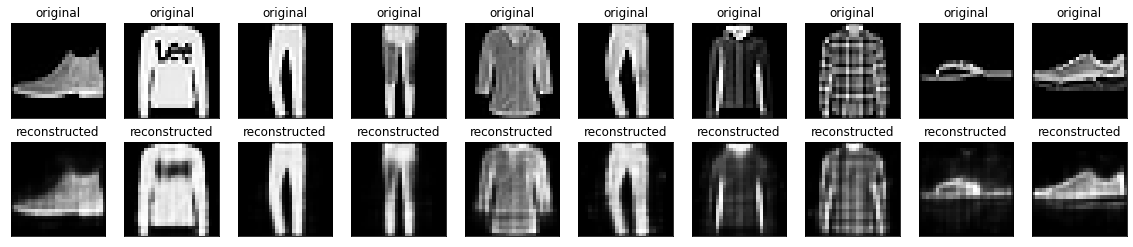

In [32]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
# 이미지 노이즈 제거 버전
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [37]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [39]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [43]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

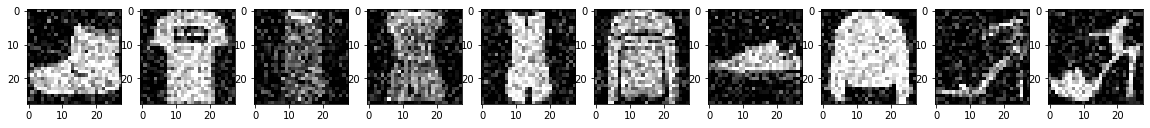

In [47]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(tf.reshape(x_train_noisy[i], (28,28)))
  plt.gray()

In [50]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = Sequential([
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
    ])
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Denoise()

In [51]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=10,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

In [57]:
encoded_images = autoencoder.encoder(x_test_noisy).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

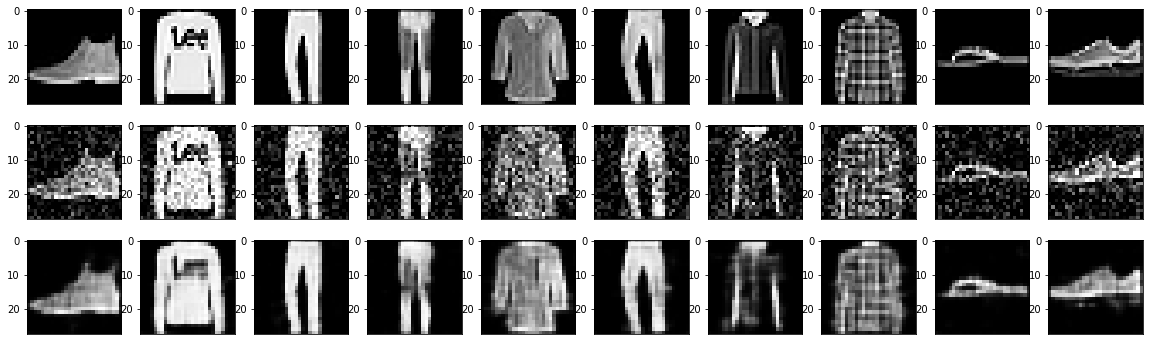

In [66]:
n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(tf.squeeze(x_test[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)


  ax = plt.subplot(3, n, i+1+n*2)
  plt.imshow(tf.squeeze(decoded_images[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
